# Airbnb San Francisco data

#### People travel for work, for pleasure and for some it is just a way of life. San Francisco has a lot to offer to travellers of any kind. The city is known for its diverse culture, fantastic scenery, unusual climate and great food. One basic need for any kind of traveller is accomodation, where he is relaxes while on the tour. These days, many people prefer listings in Airbnb compared to luxurious hotels, either based on their budget or for a family home feel or based on the size of the group. In this work, we are attempting to do an analysis on Airbnb San Francisco data to understand how a traveller makes a decision on his accomodation choice. We would like to look into 
#### - We want to see why some accomodations have high ratings compared to the rest?
#### - Why are some accomodations occupied more compared to the rest?
#### - Can we send recommendations to the hosts/owners with less ratings and occupancy for improvement?
#### - Which locality and what kind of accomodation is a traveller more like to stay at?
#### - Can we send recommendations to the travellers based on price range, description, location etc

In [133]:
# Importing standard libraries

import numpy as np #for numerical calculations
import pandas as pd #for working on dataframes

from datetime import datetime

np.random.seed(42) #for generating same set of random numbers in multiple runs

import matplotlib.pyplot as plt # for plotting
import seaborn as sns #for nicer looking plots

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Importing and understanding the data

In [3]:
listing_rawdata = pd.read_csv('listings.csv')
reviews_rawdata = pd.read_csv('reviews.csv')
calender_rawdata = pd.read_csv('calendar.csv')

In [4]:
#What is in the listing file?
print(f'Shape of the listing file: {listing_rawdata.shape}')
print(listing_rawdata.info())
listing_rawdata.iloc[:,:10].sample(10)

Shape of the listing file: (7151, 106)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7151 entries, 0 to 7150
Columns: 106 entries, id to reviews_per_month
dtypes: float64(21), int64(23), object(62)
memory usage: 5.8+ MB
None


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview
6399,30249632,https://www.airbnb.com/rooms/30249632,20190306152813,2019-03-06,Spacious & Comfortable Noe Valley Home with Views,House is located on a quiet street in Noe Vall...,The house is an Edwardian style home that has ...,House is located on a quiet street in Noe Vall...,none,The house is located on a hill in a quiet stre...
3684,18612680,https://www.airbnb.com/rooms/18612680,20190306152813,2019-03-06,Vast sunny bedroom in single family home,Lovely home with a garden. The master bedroom...,Our home has a unique curb appeal with three b...,Lovely home with a garden. The master bedroom...,none,"Grocery shopping: For little things, you can g..."
5448,26084506,https://www.airbnb.com/rooms/26084506,20190306152813,2019-03-06,"Large, unique home in quiet Portola neighborhood",A comfortable home in the Portola district of ...,The home is located on the second floor of the...,A comfortable home in the Portola district of ...,none,"The Portola district, also known as the Garden..."
2516,11242044,https://www.airbnb.com/rooms/11242044,20190306152813,2019-03-06,Nob Hill Bedroom #6,Come stay in our spacious bedroom [with a *sha...,"We are a great 6 bedroom, 4 bathroom flat in N...",Come stay in our spacious bedroom [with a *sha...,none,We are located at Sacramento and Polk Streets ...
3268,16162763,https://www.airbnb.com/rooms/16162763,20190306152813,2019-03-06,3 Bedroom Apartment close to Downtown SF,"Located in SOMA, you will be close to many SF ...",When you stay in a Zeus property you will be m...,"Located in SOMA, you will be close to many SF ...",none,NaN
5902,28450508,https://www.airbnb.com/rooms/28450508,20190306152813,2019-03-06,Spacious & Bright Edwardian Gem Atop Russian Hill,"This spacious 1400+ sf, airy and bright Edward...",The apartment is currently furnished as a form...,This spacious (Phone number hidden by Airbnb) ...,none,"Ideally located in the heart of Russian Hill, ..."
4839,23449023,https://www.airbnb.com/rooms/23449023,20190306152813,2019-03-06,Room for Two in Close-to-Everything Inner Sunset,Located in the Inner Sunset with walking dista...,NaN,Located in the Inner Sunset with walking dista...,none,NaN
239,317078,https://www.airbnb.com/rooms/317078,20190306152813,2019-03-06,Alamo Square 1 bedroom Apt. F1B,Perfect for hack reactor students or tourists....,One Bedroom apt in the center of SF. This apt ...,Perfect for hack reactor students or tourists....,none,NaN
6516,30541662,https://www.airbnb.com/rooms/30541662,20190306152813,2019-03-06,Sunny SOMA 40 Ft Ceiling Condo 8 Min to MOSCONE,"The apartment is a new (built in 2006), contem...","- Bright, relatively new (built in (Phone num...",The apartment is a new (built in (Phone number...,none,SOMA is the most conveniently located neighbor...
2986,14773204,https://www.airbnb.com/rooms/14773204,20190306152813,2019-03-06,The Mission- Streetside Sunny Apt,"Our place is in the heart of the Mission, whic...",Our place has 4Bedrooms/2 Bathrooms and is in ...,"Our place is in the heart of the Mission, whic...",none,NaN


#### We are looking at the columns 10 at a time, to be able to filter out the columns needed for our analysis. 'Listing url' doesnt look like it is adding value from any descriptive or analysis point of view. 'Scrape_id' , 'Last_scraped', 'Experiences_offered' looks suspicious with only one value, we can check if it has more than 1 unique value.

In [5]:
print(listing_rawdata['scrape_id'].unique())
print(listing_rawdata['last_scraped'].unique())
print(listing_rawdata['experiences_offered'].unique())

[20190306152813]
['2019-03-06']
['none']


#### As suspected all the 3 columns  'Scrape_id' , 'Last_scraped', 'Experiences_offered' have only one unique value and they can be removed.

In [6]:
listing_cleaned = listing_rawdata.drop(['listing_url', 'scrape_id' , 'last_scraped', 'experiences_offered'], axis=1)

In [7]:
listing_rawdata.iloc[:,10:20].sample(10)

,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id
7011,The Donatello is a timeshare property; however...,Getting around the city is convenient using MU...,Fitness room Hot Tub Sauna Lounge,"As a timeshare owner, we will not be on-site, ...","As Timeshare Owners, we call in a non-refundab...",NaN,NaN,https://a0.muscache.com/im/pictures/bbededdd-d...,NaN,64646820
4395,"During the day, during the week, parking is ea...",NaN,Guests are free to use the kitchen for cooking...,"I am retired electrical engineer, so basically...",NaN,NaN,NaN,https://a0.muscache.com/im/pictures/aa873f9c-3...,NaN,157074592
3750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/1a721fd4-9...,NaN,59258209
5400,• This unit is on third floor and there is no ...,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/29550383-a...,NaN,48005494
4654,NaN,Parking is easy and plentiful in front of the ...,You have access to the entire flat through you...,We live in the flat on the second level and we...,- Quiet hours after 10pm. No parties.,NaN,NaN,https://a0.muscache.com/im/pictures/45de24f1-9...,NaN,8551269
3331,The neighborhood is quiet and peaceful. Since...,"From our home you can find easy parking, or ta...",In our space you will be able to access our sh...,We will be available throughout your stay for ...,- Please leave shoes at the door and be mindfu...,NaN,NaN,https://a0.muscache.com/im/pictures/d881f728-1...,NaN,22664977
4187,NaN,About a 10 minute walk to Glen Park bart which...,"All spaces are open including living, dining, ...",Available via phone or the AirBNB messaging ap...,"- While this is a house, we do have neighbors ...",NaN,NaN,https://a0.muscache.com/im/pictures/63204e36-7...,NaN,56971
3852,- We're on the 3rd floor and there's no elevat...,5 min bike ride/7 minute walk to 24th & Missio...,A beautiful living space and shared backyard p...,We're always happy to share recommendations an...,- Our house rules are pretty simple: Please be...,NaN,NaN,https://a0.muscache.com/im/pictures/d2757333-c...,NaN,120435565
6379,NaN,NaN,this apartment does not have any private exter...,looking forward to meeting you when you arrive...,- additional contract to be signed upon arrival,NaN,NaN,https://a0.muscache.com/im/pictures/292c01db-d...,NaN,13062241
5452,• Sometimes you can hear noise from your neigh...,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/436d412f-c...,NaN,48005494


#### 'thumbnail_url', 'medium_url',	'picture_url',	'xl_picture_url' can be removed.

In [8]:
listing_cleaned = listing_cleaned.drop(['thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url'], axis=1)

In [9]:
listing_rawdata.iloc[:,20:30].sample(10)

,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url
3351,https://www.airbnb.com/users/show/53195251,Rolando,2016-01-03,"San Francisco, California, United States","Love traveling from my home in San Francisco, ...",within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/468ccffa-7...
3620,https://www.airbnb.com/users/show/3839305,Michael,2012-10-11,"San Francisco, California, United States","Born in Toledo, Ohio, Raised in Napa, CA and D...",within an hour,96%,NaN,t,https://a0.muscache.com/im/users/3839305/profi...
7047,https://www.airbnb.com/users/show/242756307,Sergey,2019-02-12,US,NaN,within a few hours,100%,NaN,f,https://a0.muscache.com/im/pictures/user/5068c...
1440,https://www.airbnb.com/users/show/1257432,Rebecca,2011-10-06,"San Francisco, California, United States","Owner at San Francisco Life Real Estate, Inc. ...",within an hour,97%,NaN,t,https://a0.muscache.com/im/pictures/user/f54c1...
4168,https://www.airbnb.com/users/show/151803493,Joseph,2017-09-23,San Francisco / Los Angeles / Texas / East Coast,NaN,within a day,100%,NaN,f,https://a0.muscache.com/im/pictures/user/a6d11...
563,https://www.airbnb.com/users/show/5539889,Danny,2013-03-19,"San Francisco, California, United States","We are San Francisco residents, and we love to...",within a day,50%,NaN,f,https://a0.muscache.com/im/pictures/5b24d320-a...
6832,https://www.airbnb.com/users/show/57820905,Gabrielle,2016-02-07,"San Francisco, California, United States",Hi! I’ve lived in San Francisco for five years...,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/7ce33950-4...
5728,https://www.airbnb.com/users/show/4497462,Peter,2012-12-26,"San Francisco, California, United States","I work in Tech, focused mainly on consulting r...",within a few hours,100%,NaN,f,https://a0.muscache.com/im/pictures/user/e0c17...
1377,https://www.airbnb.com/users/show/22662933,Leslie,2014-10-17,"San Francisco, California, United States","As a native Californian, I am excited to help...",within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/user/0c612...
4498,https://www.airbnb.com/users/show/48005494,Zeus,2015-11-02,"San Francisco, California, United States",Zeus is reinventing corporate housing. We do t...,within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/user/7776f...


#### 'host_url',	'host_id', 'host_thumbnail_url' can be removed. 'host_acceptance_rate' looks suspicious with NaN values only.

In [10]:
print(listing_rawdata['host_acceptance_rate'].unique())

[nan]


#### 'host_acceptance_rate' can be removed.

In [11]:
listing_cleaned = listing_cleaned.drop(['host_url', 'host_id', 'host_thumbnail_url', 'host_acceptance_rate'], axis=1)

In [12]:
listing_rawdata.iloc[:,30:45].sample(20)

,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market
2579,https://a0.muscache.com/im/pictures/59aa137a-3...,Downtown,106,106,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"San Francisco, CA, United States",Downtown,Downtown/Civic Center,NaN,San Francisco,CA,94109,San Francisco
5505,https://a0.muscache.com/im/pictures/user/5f576...,SoMa,2,2,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"San Francisco, CA, United States",SoMa,South of Market,NaN,San Francisco,CA,94103,San Francisco
4694,https://a0.muscache.com/im/users/2781147/profi...,Cole Valley,1,1,"['email', 'phone', 'facebook', 'google', 'revi...",t,t,"San Francisco, CA, United States",Cole Valley,Haight Ashbury,NaN,San Francisco,CA,94117,San Francisco
6630,https://a0.muscache.com/im/pictures/user/24726...,Inner Sunset,1,1,"['email', 'phone', 'reviews']",t,f,"San Francisco, CA, United States",Inner Sunset,Inner Sunset,NaN,San Francisco,CA,94131,San Francisco
919,https://a0.muscache.com/im/pictures/00736b86-2...,Duboce Triangle,1,1,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"San Francisco, CA, United States",Duboce Triangle,Castro/Upper Market,NaN,San Francisco,CA,94114,San Francisco
3917,https://a0.muscache.com/im/pictures/d5a490df-5...,Crocker Amazon,1,1,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"San Francisco, CA, United States",Crocker Amazon,Crocker Amazon,NaN,San Francisco,CA,94112,San Francisco
6075,https://a0.muscache.com/im/pictures/32e78754-a...,Haight-Ashbury,3,3,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"San Francisco, CA, United States",Haight-Ashbury,Haight Ashbury,NaN,San Francisco,CA,94117,San Francisco
2742,https://a0.muscache.com/im/users/3617002/profi...,Potrero Hill,7,7,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,"San Francisco, CA, United States",Potrero Hill,Potrero Hill,NaN,San Francisco,CA,94107,San Francisco
6583,https://a0.muscache.com/im/pictures/user/2b30e...,Potrero Hill,1,1,"['email', 'phone', 'offline_government_id', 'g...",t,f,"San Francisco, CA, United States",Potrero Hill,Potrero Hill,NaN,San Francisco,CA,94107,San Francisco
2304,https://a0.muscache.com/im/pictures/dcd41fcf-f...,Mission Terrace,9,9,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"San Francisco, CA, United States",Mission Terrace,Outer Mission,NaN,San Francisco,CA,94112,San Francisco


#### 'host_picture_url' can be removed.
#### 'host_listings_count', 'host_total_listings_count' convey the same information.
#### we need to look for unique values in 'street', 'city', 'state', 'market'
#### 'neighbourhood', 'neighbourhood_cleansed',	'neighbourhood_group_cleansed' contains similar information. We will keep 'neighbourhood_cleansed' and drop the others.

In [13]:
print(listing_rawdata['street'].unique())
print(listing_rawdata['city'].unique())
print(listing_rawdata['state'].unique())
print(listing_rawdata['market'].unique())

['San Francisco, CA, United States'
 'Bernal Heights, San Francisco, CA, United States'
 'San Francisco, Hayes Valley, CA, United States'
 'Noe Valley - San Francisco, CA, United States'
 'South San Francisco, CA, United States' 'Daly City, CA, United States'
 'CA, CA, United States' 'San Francisco, Mexico'
 'San Francisco , CA, United States' 'San Francisco, Ca, United States']
['San Francisco' 'Bernal Heights, San Francisco'
 'San Francisco, Hayes Valley' 'Noe Valley - San Francisco'
 'South San Francisco' 'Daly City' nan 'San Francisco ']
['CA' nan 'Ca']
['San Francisco' nan]


#### We can remove 'state' and 'market'.

In [14]:
listing_cleaned = listing_cleaned.drop(['host_picture_url', 'host_listings_count', 'state', 'market', 
                                       'neighbourhood', 'neighbourhood_group_cleansed'], axis=1)

In [15]:
listing_rawdata.iloc[:,45:60].sample(5)

,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet
1353,"San Francisco, CA",US,United States,37.75039,-122.43893,t,Apartment,Entire home/apt,6,2.0,2.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free str...",NaN
5715,"San Francisco, CA",US,United States,37.75557,-122.41907,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,Kitchen,""Smoking allowed"",Heating,Was...",NaN
4124,"San Francisco, CA",US,United States,37.78800,-122.41820,t,Apartment,Private room,4,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,""Paid parking off ...",NaN
710,"San Francisco, CA",US,United States,37.76054,-122.40961,t,Loft,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,Kitchen,Elevator,""Buzzer/wireless int...",NaN
3388,"San Francisco, CA",US,United States,37.74189,-122.42124,f,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Pets all...",NaN


#### 'smart_location', 'country_code', 'country' can be removed
#### need to check if 'bed_type' is unique and if 'square_feet' has all Nan's

In [16]:
print(listing_rawdata['bed_type'].unique())
print(listing_rawdata['square_feet'].unique())

['Real Bed' 'Futon' 'Airbed' 'Pull-out Sofa' 'Couch']
[      nan 1.019e+03 6.000e+02 3.000e+02 1.850e+03 8.000e+02 2.200e+03
 1.200e+03 2.500e+02 7.000e+02 5.000e+02 1.500e+03 4.000e+02 1.750e+02
 5.380e+02 1.000e+00 1.390e+03 1.500e+02 8.530e+02 2.100e+03 2.300e+03
 2.600e+03 1.300e+02 9.000e+02 7.500e+02 1.400e+02 1.200e+02 1.300e+03
 1.900e+03 2.000e+00 1.000e+03 4.010e+02 3.600e+02 9.500e+02 1.400e+03
 6.500e+02 2.000e+03 2.800e+02 1.800e+03 2.250e+03 8.400e+02 1.400e+01
 2.700e+03 1.490e+03 4.500e+02 8.900e+02 1.996e+03 1.600e+02 3.000e+03
 1.250e+03 1.100e+03 0.000e+00 1.950e+02 1.660e+03 1.600e+03 8.500e+02
 1.750e+03 7.800e+02 5.500e+02 8.100e+02 8.150e+02 1.700e+03]


In [17]:
listing_cleaned = listing_cleaned.drop(['smart_location', 'country_code', 'country'], axis=1)

In [18]:
listing_rawdata.iloc[:,60:80].sample(5)

,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90
212,$250.00,"$1,436.00",NaN,"$5,000.00",$50.00,2,$100.00,2,30,2,2,30,30,2.0,30.0,4 days ago,t,6,20,23
5289,$95.00,NaN,NaN,$0.00,$35.00,2,$100.00,30,1125,30,30,1125,1125,30.0,1125.0,2 months ago,t,29,59,89
6007,$70.00,NaN,NaN,NaN,NaN,1,$0.00,30,30,30,30,30,30,30.0,30.0,5 months ago,t,0,0,0
6004,$150.00,NaN,NaN,$150.00,$30.00,1,$0.00,2,60,2,2,60,60,2.0,60.0,5 months ago,t,29,59,89
6063,$600.00,NaN,NaN,$100.00,$50.00,1,$0.00,2,2,2,2,2,2,2.0,2.0,5 months ago,t,0,0,0


#### We need to check if 'weekly_price' and 'monthly_price' has unique values other than Nan.
#### 'minimum_minimum_nights',	'maximum_minimum_nights',	'minimum_maximum_nights',	'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm' can be removed.

In [19]:
print(listing_rawdata['weekly_price'].unique())
print(listing_rawdata['monthly_price'].unique())

['$1,120.00' '$1,600.00' '$485.00' '$490.00' nan '$1,000.00' '$1,540.00'
 '$630.00' '$2,300.00' '$1,188.00' '$1,220.00' '$750.00' '$945.00'
 '$1,021.00' '$1,049.00' '$800.00' '$900.00' '$1,100.00' '$9,999.00'
 '$1,250.00' '$1,200.00' '$470.00' '$1,199.00' '$875.00' '$2,450.00'
 '$690.00' '$600.00' '$950.00' '$958.00' '$799.00' '$3,100.00' '$1,050.00'
 '$2,630.00' '$329.00' '$1,500.00' '$550.00' '$1,800.00' '$2,900.00'
 '$850.00' '$1,026.00' '$775.00' '$3,150.00' '$2,500.00' '$2,100.00'
 '$700.00' '$560.00' '$2,700.00' '$2,675.00' '$650.00' '$2,279.00'
 '$1,550.00' '$1,900.00' '$770.00' '$3,500.00' '$1,350.00' '$500.00'
 '$1,365.00' '$1,595.00' '$2,200.00' '$964.00' '$680.00' '$1,160.00'
 '$645.00' '$1,436.00' '$930.00' '$1,323.00' '$2,000.00' '$840.00'
 '$1,700.00' '$960.00' '$1,300.00' '$818.00' '$980.00' '$1,175.00'
 '$697.00' '$2,795.00' '$995.00' '$869.00' '$1,850.00' '$599.00' '$893.00'
 '$910.00' '$1,400.00' '$1,568.00' '$1,999.00' '$3,199.00' '$3,000.00'
 '$2,250.00' '$570.00' '

#### 'weekly_price' and 'monthly_price' have unique values

In [20]:
listing_cleaned = listing_cleaned.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 
                                        'minimum_maximum_nights', 'maximum_maximum_nights', 
                                        'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
                                       'availability_60', 'availability_90', 'availability_365'], axis=1)

In [21]:
listing_rawdata.iloc[:,80:95].sample(5)

,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license
1341,64,2019-03-06,16,6,2015-05-27,2019-01-06,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,STR-0003174
83,277,2019-03-06,12,0,2011-05-29,2018-02-18,96.0,9.0,10.0,10.0,10.0,9.0,9.0,t,NaN
162,316,2019-03-06,99,19,2011-08-19,2019-02-08,96.0,10.0,9.0,10.0,10.0,10.0,10.0,t,STR-0000875
465,0,2019-03-06,4,3,2016-08-10,2018-11-17,100.0,10.0,9.0,10.0,10.0,10.0,10.0,t,NaN
6985,43,2019-03-06,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,NaN


#### 'calendar_last_scraped', 'license' can be removed.
#### We can check if 'requires_license' is unique

In [22]:
print(listing_rawdata['requires_license'].unique())

['t' 'f']


In [23]:
listing_cleaned = listing_cleaned.drop(['calendar_last_scraped', 'license'], axis=1)

In [24]:
listing_rawdata.iloc[:,95:107].sample(5)

,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
6008,"{""SAN FRANCISCO""}",f,f,moderate,f,f,3,1,2,0,0.48
3121,"{""SAN FRANCISCO""}",t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.44
2486,"{""SAN FRANCISCO""}",t,f,flexible,f,f,36,11,25,0,0.16
753,"{""SAN FRANCISCO""}",f,f,moderate,f,f,1,1,0,0,1.52
561,"{""SAN FRANCISCO""}",f,f,moderate,f,f,2,0,2,0,3.57


####  We can see if 'jurisdiction_names',	'instant_bookable',	'is_business_travel_ready', 'require_guest_profile_picture', 	'require_guest_phone_verification' are unique.
#### We already have information on host_listings_count, we can remove 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',	'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'.

In [25]:
print(listing_rawdata['jurisdiction_names'].unique())
print(listing_rawdata['instant_bookable'].unique())
print(listing_rawdata['require_guest_profile_picture'].unique())
print(listing_rawdata['require_guest_phone_verification'].unique())

['{"SAN FRANCISCO"}' nan]
['t' 'f']
['f' 't']
['f' 't']


#### 'jurisdiction_names' can be removed.

In [26]:
listing_cleaned = listing_cleaned.drop(['jurisdiction_names', 'calculated_host_listings_count',
                                        'calculated_host_listings_count_entire_homes',
                                        'calculated_host_listings_count_private_rooms', 
                                        'require_guest_profile_picture',
                                        'is_business_travel_ready',
                                        'calculated_host_listings_count_shared_rooms'], axis=1)

In [27]:
listing_cleaned.shape

(7151, 67)

In [28]:
listing_cleaned.head()

,id,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_phone_verification,reviews_per_month
0,958,"Bright, Modern Garden Unit - 1BR/1B",New update: the house next door is under const...,"Newly remodeled, modern, and bright garden uni...",New update: the house next door is under const...,*Quiet cul de sac in friendly neighborhood *St...,Due to the fact that we have children and a do...,*Public Transportation is 1/2 block away. *Ce...,*Full access to patio and backyard (shared wit...,A family of 4 lives upstairs with their dog. N...,...,10.0,10.0,10.0,10.0,10.0,t,t,moderate,f,1.54
1,5858,Creative Sanctuary,NaN,We live in a large Victorian house on a quiet ...,We live in a large Victorian house on a quiet ...,I love how our neighborhood feels quiet but is...,All the furniture in the house was handmade so...,The train is two blocks away and you can stop ...,"Our deck, garden, gourmet kitchen and extensiv...",NaN,...,10.0,10.0,10.0,10.0,9.0,t,f,strict_14_with_grace_period,f,0.93
2,7918,A Friendly Room - UCSF/USF - San Francisco,Nice and good public transportation. 7 minute...,Room rental-sunny view room/sink/Wi Fi (inner ...,Nice and good public transportation. 7 minute...,"Shopping old town, restaurants, McDonald, Whol...",Please email your picture id with print name (...,N Juda Muni and bus stop. Street parking.,NaN,NaN,...,8.0,9.0,9.0,9.0,8.0,t,f,strict_14_with_grace_period,f,0.15
3,8142,Friendly Room Apt. Style -UCSF/USF - San Franc...,Nice and good public transportation. 7 minute...,Room rental Sunny view Rm/Wi-Fi/TV/sink/large ...,Nice and good public transportation. 7 minute...,NaN,Please email your picture id with print name (...,"N Juda Muni, Bus and UCSF Shuttle. small shopp...",NaN,NaN,...,9.0,10.0,10.0,9.0,9.0,t,f,strict_14_with_grace_period,f,0.15
4,8339,Historic Alamo Square Victorian,Pls email before booking. Interior featured i...,Please send us a quick message before booking ...,Pls email before booking. Interior featured i...,NaN,tax ID on file tax ID on file,NaN,Guests have access to everything listed and sh...,NaN,...,10.0,10.0,10.0,10.0,9.0,t,f,strict_14_with_grace_period,t,0.23


In [29]:
listing_cleaned.isnull().sum()

id                                     0
name                                   0
summary                              200
space                               1075
description                           21
neighborhood_overview               1902
notes                               2743
transit                             2020
access                              2386
interaction                         2292
house_rules                         1922
host_name                              0
host_since                             0
host_location                          9
host_about                          1704
host_response_time                   725
host_response_rate                   725
host_is_superhost                      0
host_neighbourhood                   642
host_total_listings_count              0
host_verifications                     0
host_has_profile_pic                   0
host_identity_verified                 0
street                                 0
neighbourhood_cl

In [30]:
# Checking the uniqueness of 'id'
print(pd.Series(listing_cleaned['id']).nunique())

# checking randomly if the host's total listings match the host_listing_count
listing_rawdata[listing_rawdata['host_name'] == 'Rolando']


7151


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
2469,10956845,https://www.airbnb.com/rooms/10956845,20190306152813,2019-03-06,Spacious Shared SF Classic n Marina,"Great shared living location, easy access to c...",There's a shared front room and kitchen. Room ...,"Great shared living location, easy access to c...",none,Can walk to marina district(union/chestnut st....,...,f,f,strict_14_with_grace_period,f,f,2,0,2,0,0.13
3351,16570808,https://www.airbnb.com/rooms/16570808,20190306152813,2019-03-06,Spacious Shared SF Classic in the Marina,"Great shared living location, easy access to c...",Kitchen and tv area is available,"Great shared living location, easy access to c...",none,Union street and chestnut st.,...,f,f,flexible,f,f,2,0,2,0,0.24


#### It is clear that each row/each observation belongs to a unique id - and an id is unique to a house/apartment/room.

In [31]:
listing_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7151 entries, 0 to 7150
Data columns (total 67 columns):
id                                  7151 non-null int64
name                                7151 non-null object
summary                             6951 non-null object
space                               6076 non-null object
description                         7130 non-null object
neighborhood_overview               5249 non-null object
notes                               4408 non-null object
transit                             5131 non-null object
access                              4765 non-null object
interaction                         4859 non-null object
house_rules                         5229 non-null object
host_name                           7151 non-null object
host_since                          7151 non-null object
host_location                       7142 non-null object
host_about                          5447 non-null object
host_response_time                  642

In [32]:
#creating a list of all columns which are strings
columns = listing_cleaned.columns
numeric_columns = listing_cleaned._get_numeric_data().columns
string_columns= list(set(columns) - set(numeric_columns))

#listing_cleaned[string_columns].iloc[:,30:46].head()


In [33]:
zero_one = ['host_about', 'description', 'transit', 'neighborhood_overview', 'space', 'house_rules', 'name',
            'access', 'amenities', 'summary']
true_false = ['requires_license', 'instant_bookable','require_guest_phone_verification', 
              'has_availability', 'host_is_superhost', 'is_location_exact', 
              'host_has_profile_pic', 'host_identity_verified']
dollars_numbers= ['cleaning_fee', 'security_deposit', 'price', 'monthly_price', 'weekly_price', 'extra_people']
percent_numbers= ['host_response_rate']
unwanted = ['first_review', 'host_neighbourhood', 'city','street','notes', 'host_verifications','zipcode', 'interaction']

In [34]:
wanted = list(set(columns)-set(unwanted))

In [35]:
listing_cleaned[zero_one]

,host_about,description,transit,neighborhood_overview,space,house_rules,name,access,amenities,summary
0,We are a family with 2 boys born in 2009 and 2...,New update: the house next door is under const...,*Public Transportation is 1/2 block away. *Ce...,*Quiet cul de sac in friendly neighborhood *St...,"Newly remodeled, modern, and bright garden uni...",* No Pets - even visiting guests for a short t...,"Bright, Modern Garden Unit - 1BR/1B",*Full access to patio and backyard (shared wit...,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Pets liv...",New update: the house next door is under const...
1,Philip: English transplant to the Bay Area and...,We live in a large Victorian house on a quiet ...,The train is two blocks away and you can stop ...,I love how our neighborhood feels quiet but is...,We live in a large Victorian house on a quiet ...,"Please respect the house, the art work, the fu...",Creative Sanctuary,"Our deck, garden, gourmet kitchen and extensiv...","{Internet,Wifi,Kitchen,Heating,""Family/kid fri...",NaN
2,7 minutes walk to UCSF. 15 minutes walk to US...,Nice and good public transportation. 7 minute...,N Juda Muni and bus stop. Street parking.,"Shopping old town, restaurants, McDonald, Whol...",Room rental-sunny view room/sink/Wi Fi (inner ...,"No party, No smoking, not for any kinds of smo...",A Friendly Room - UCSF/USF - San Francisco,NaN,"{TV,Internet,Wifi,Kitchen,""Free street parking...",Nice and good public transportation. 7 minute...
3,7 minutes walk to UCSF. 15 minutes walk to US...,Nice and good public transportation. 7 minute...,"N Juda Muni, Bus and UCSF Shuttle. small shopp...",NaN,Room rental Sunny view Rm/Wi-Fi/TV/sink/large ...,no pet no smoke no party inside the building,Friendly Room Apt. Style -UCSF/USF - San Franc...,NaN,"{TV,Internet,Wifi,Kitchen,""Free street parking...",Nice and good public transportation. 7 minute...
4,Always searching for a perfect piece at Europe...,Pls email before booking. Interior featured i...,NaN,NaN,Please send us a quick message before booking ...,House Manual and House Rules will be provided ...,Historic Alamo Square Victorian,Guests have access to everything listed and sh...,"{TV,Internet,Wifi,Kitchen,Heating,""Family/kid ...",Pls email before booking. Interior featured i...
5,"We are a family of three who love live music,...","Fully furnished 2BR, 1BA flat in beautiful Vic...",We're 2 blocks from several bus lines that can...,"The neighborhood is very centrally located, cl...","Fully furnished 2BR, 1BA flat in beautiful Vic...","No smoking, as I'm quite allergic. Please put ...",Lovely 2BR flat Great Location,NaN,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free par...",NaN
6,Ivan is a publisher of a book for 4 year olds....,"Welcome to ""The Mission,"" the sunniest neighbo...",It's an easy and enjoyable 10 minute stroll to...,Located between Valencia Street and Dolores Pa...,"Your sunny room looks out over a lush garden, ...","PLEASE: Read through our entire listing, as we...","Mission Sunshine, with Private Bath",You'll have your own bedroom and private bathr...,"{TV,""Cable TV"",Internet,Wifi,""Paid parking off...","Welcome to ""The Mission,"" the sunniest neighbo..."
7,The apartment is on the ground floor of the ho...,A Unique Guest Suite! A Spacious Art Filled ...,There are buses within a block to connect to a...,"It is a distinct neighborhood, with easy acces...","It is unique, very spacious [800 sq. ft. with...",We are respectful of the privacy of our renter...,Artful Potrero Separate Floor with Garden,"Laundry privileges, Spacious Garden with City ...","{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free par...",A Unique Guest Suite! A Spacious Art Filled ...
8,Coming from SF.,Please read this before you book! Second floor...,"SF Muni line 12, bus stop is a block away from...","Neighborhood is safe, sunny, lively and fun. ...",Please read this before you book! Second floor...,Basic rules: No smoking inside the suite or on...,Victorian Suite in Inner Mission,You are w

In [36]:
# Recoding descriptive status to zero and one
for i in zero_one:
    length = listing_cleaned[i].str.len()
    listing_cleaned[i] = length
    listing_cleaned[i] = listing_cleaned[i].fillna(0)

In [37]:
# Recoding t/f to 1/0
for i in true_false:
    listing_cleaned[i] = listing_cleaned[i].replace({'t':1, 'f':0})

In [38]:
# Recoding dollar string values to numbers
for i in dollars_numbers:
    listing_cleaned[i].fillna(0)
    listing_cleaned[i] = listing_cleaned[i].str.replace('$','')
    listing_cleaned[i] = listing_cleaned[i].str.replace(',','').astype('float').fillna(0)

In [39]:
#Recoding % to number
for i in percent_numbers:
    listing_cleaned[i] = listing_cleaned[i].str.replace('%','').astype('float')
    listing_cleaned[i] = listing_cleaned[i].apply(lambda x: x/100)
    

In [40]:
listing_clean = listing_cleaned[wanted]
listing_clean.head()

,host_has_profile_pic,description,security_deposit,id,house_rules,maximum_nights,host_is_superhost,bedrooms,property_type,price,...,room_type,number_of_reviews,host_name,calendar_updated,weekly_price,neighbourhood_cleansed,availability_30,guests_included,review_scores_cleanliness,minimum_nights
0,1,1000.0,100.0,958,110.0,30,1,1.0,Apartment,170.0,...,Entire home/apt,180,Holly,today,1120.0,Western Addition,1,2,10.0,1
1,1,1000.0,0.0,5858,67.0,60,0,2.0,Apartment,235.0,...,Entire home/apt,111,Philip And Tania,3 months ago,1600.0,Bernal Heights,0,2,10.0,30
2,1,1000.0,200.0,7918,88.0,60,0,1.0,Apartment,65.0,...,Private room,17,Aaron,16 months ago,485.0,Haight Ashbury,30,1,8.0,32
3,1,1000.0,200.0,8142,44.0,90,0,1.0,Apartment,65.0,...,Private room,8,Aaron,16 months ago,490.0,Haight Ashbury,30,1,9.0,32
4,1,1000.0,0.0,8339,303.0,1125,0,2.0,House,785.0,...,Entire home/apt,27,Rosy,3 months ago,0.0,Western Addition,30,2,10.0,7


In [41]:
date_time = ['host_since', 'last_review']
last_scraped_date = pd.to_datetime("2019-03-06")
for i in date_time:
    listing_clean[i] = (last_scraped_date - pd.to_datetime(listing_clean[i]))
    
# Host since and last review have null values - need to fill values
listing_clean['last_review'] = listing_clean['last_review'].fillna(listing_clean['last_review'].max())
listing_clean['host_since'] = listing_clean['host_since'].fillna(listing_clean['host_since'].min())

#Recoding Nan as no response for host_response_time
listing_clean['host_response_time'] = listing_clean['host_response_time'].fillna('no response')

#Recoding calender updates done less than a week ago as 1 and more than that 0
recent = ['today', 'yesterday', 'a week ago', '1 week ago', '2 days ago','3 days ago', '4 days ago', '5 days ago', '6 days ago']
old = list(set(listing_clean['calendar_updated'])- set(recent))
listing_clean['calendar_updated'] = listing_clean['calendar_updated'].replace(recent,1).replace(old,0)

#recode host_location as 1 if he is in california else 0
listing_clean["host_location"] = listing_clean["host_location"].str.split(", ", n = 2, expand = True)[1]
california_names = ['California', 'CA']
other_names = list(set(listing_clean['host_location'])- set(california_names))
listing_clean['host_location'] = listing_clean['host_location'].replace(california_names,1).replace(other_names,0)

In [42]:
#Filling na's for the rest of the columns
listing_clean["host_response_rate"] = listing_clean["host_response_rate"].fillna(0.5)

listing_clean["bathrooms"] = listing_clean["bathrooms"].fillna(listing_clean['bathrooms'].median())
listing_clean['bedrooms'] = listing_clean['bedrooms'].fillna(listing_clean['bedrooms'].median())

#Removing square_feet since it has 7000 null values
listing_clean = listing_clean.drop(['square_feet'], axis=1)

In [43]:
listing_clean['review_scores_rating'] = listing_clean['review_scores_rating'].fillna(1)
listing_clean['number_of_reviews'] = listing_clean['number_of_reviews'].replace(0, 0.5)

In [44]:
listing_clean["feature_review_score"] = listing_clean['review_scores_rating']*listing_clean['number_of_reviews']

In [45]:
listing_clean = listing_clean.fillna(0)

In [46]:
listing_clean.head()

,host_has_profile_pic,description,security_deposit,id,house_rules,maximum_nights,host_is_superhost,bedrooms,property_type,price,...,number_of_reviews,host_name,calendar_updated,weekly_price,neighbourhood_cleansed,availability_30,guests_included,review_scores_cleanliness,minimum_nights,feature_review_score
0,1,1000.0,100.0,958,110.0,30,1,1.0,Apartment,170.0,...,180.0,Holly,1,1120.0,Western Addition,1,2,10.0,1,17460.0
1,1,1000.0,0.0,5858,67.0,60,0,2.0,Apartment,235.0,...,111.0,Philip And Tania,0,1600.0,Bernal Heights,0,2,10.0,30,10878.0
2,1,1000.0,200.0,7918,88.0,60,0,1.0,Apartment,65.0,...,17.0,Aaron,0,485.0,Haight Ashbury,30,1,8.0,32,1445.0
3,1,1000.0,200.0,8142,44.0,90,0,1.0,Apartment,65.0,...,8.0,Aaron,0,490.0,Haight Ashbury,30,1,9.0,32,744.0
4,1,1000.0,0.0,8339,303.0,1125,0,2.0,House,785.0,...,27.0,Rosy,0,0.0,Western Addition,30,2,10.0,7,2619.0


## Exploratory Data Analysis

#### Since we have cleaned the data thoroughly, we can now go ahead to understand our dataset better, by doing an exploratory data analysis

Text(0, 0.5, 'Count')

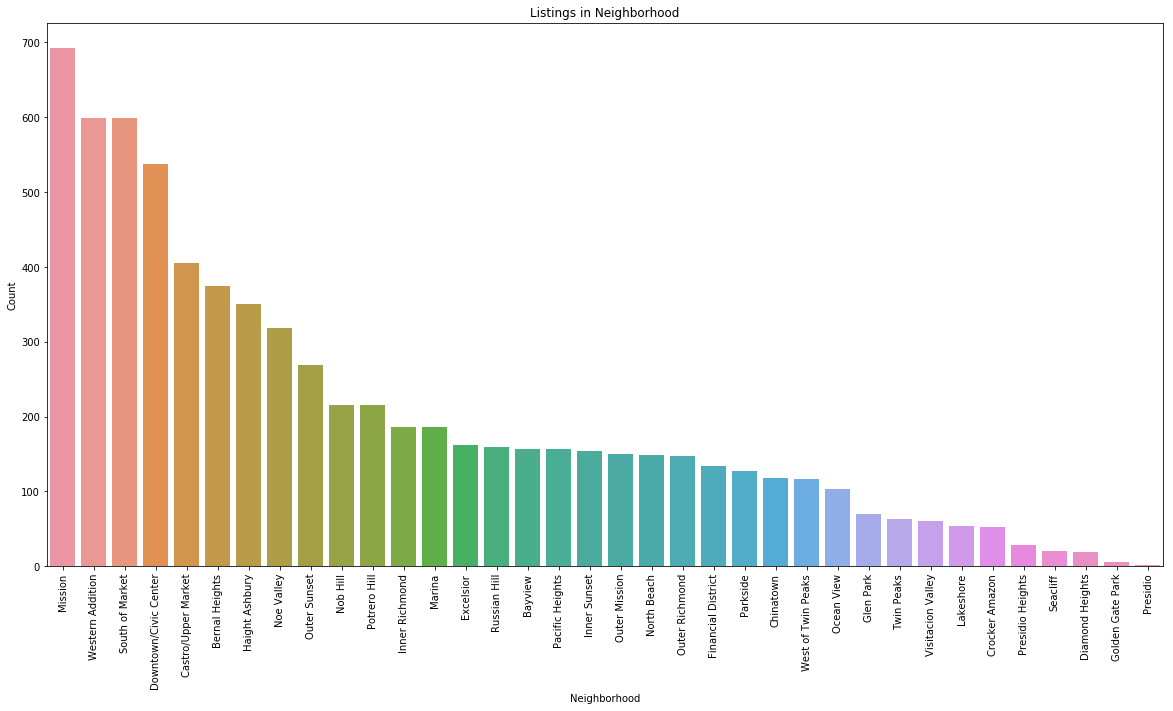

In [47]:
#Listings by neighborhoods
count, ax = plt.subplots(figsize = (20,10))
ax = sns.countplot('neighbourhood_cleansed', data=listing_clean,
                   order=listing_clean['neighbourhood_cleansed'].value_counts().index)
ax.set_title('Listings in Neighborhood')
plt.xticks(rotation=90)
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Count')

#### From the plot, top three neighborhoods with maximum number of listings are Mission, Western Addition and South of Market. Presidio has the least number of listings in Airbnb.

Text(0, 0.5, 'Count')

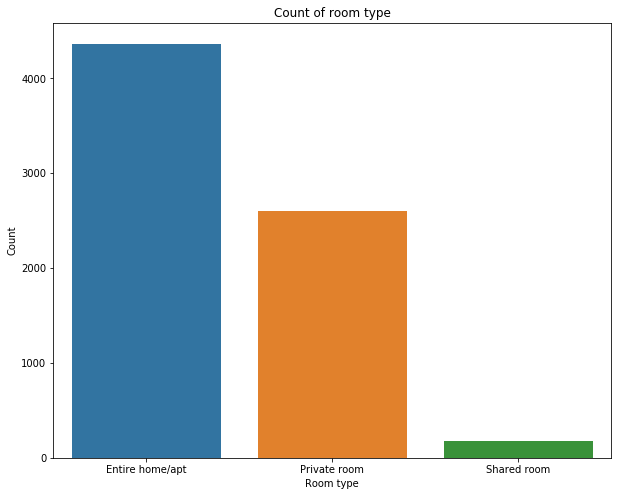

In [48]:
#Listings by room type
count, ax = plt.subplots(figsize=(10,8))
ax = sns.countplot('room_type', data=listing_clean)
ax.set_title('Count of room type')
ax.set_xlabel('Room type')
ax.set_ylabel('Count')

In [49]:
listing_clean['room_type'].value_counts()

Entire home/apt    4366
Private room       2606
Shared room         179
Name: room_type, dtype: int64

#### The plot above clearly shows that most of the listings (~60%) in Airbnb are for entire home/apartment, followed by private room listings (37%). Shared room listings only account for ~3% of the total listings.

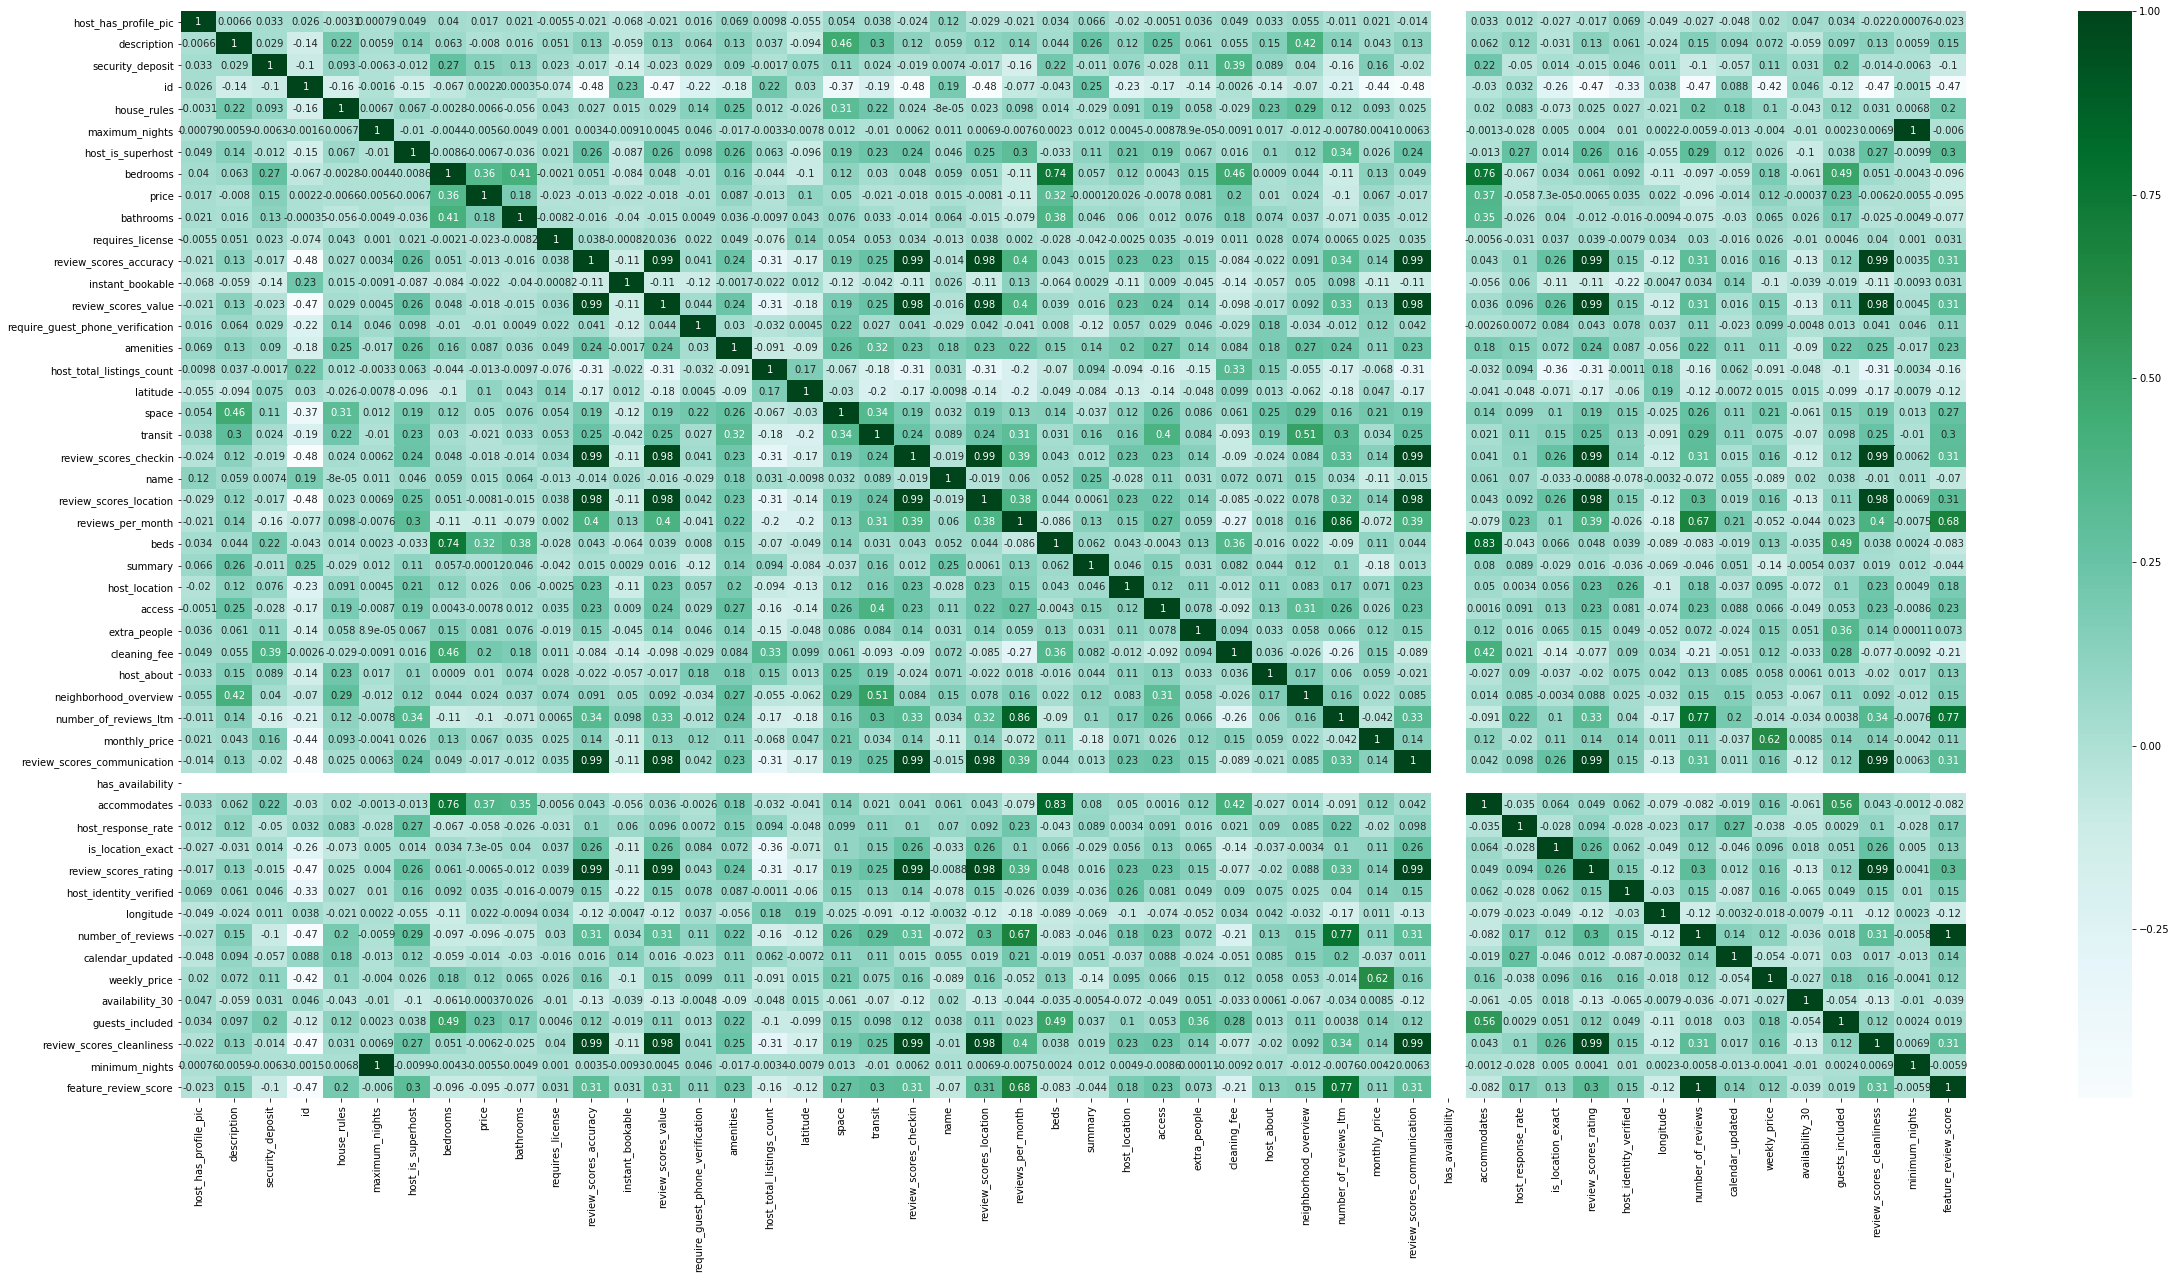

In [50]:
#Correlation plot
plt.rcParams["figure.figsize"] = "40,20"
sns.heatmap(listing_clean.corr(), annot=True, cmap='BuGn')

In [51]:
listing_clean.columns

Index(['host_has_profile_pic', 'description', 'security_deposit', 'id',
       'house_rules', 'maximum_nights', 'host_is_superhost', 'bedrooms',
       'property_type', 'price', 'bed_type', 'bathrooms', 'requires_license',
       'review_scores_accuracy', 'instant_bookable', 'review_scores_value',
       'cancellation_policy', 'host_response_time',
       'require_guest_phone_verification', 'amenities',
       'host_total_listings_count', 'latitude', 'host_since', 'space',
       'transit', 'review_scores_checkin', 'name', 'review_scores_location',
       'reviews_per_month', 'beds', 'summary', 'host_location', 'access',
       'extra_people', 'cleaning_fee', 'host_about', 'neighborhood_overview',
       'last_review', 'number_of_reviews_ltm', 'monthly_price',
       'review_scores_communication', 'has_availability', 'accommodates',
       'host_response_rate', 'is_location_exact', 'review_scores_rating',
       'host_identity_verified', 'longitude', 'room_type', 'number_of_reviews',
 

## Prediction for review score

#### The first problem which would like to look at is - prediction of review score given the features. We can now proceed to further filter the existing dataframe for this purpose by removing things like calender updated, name, summary which will not have an impact on review score.

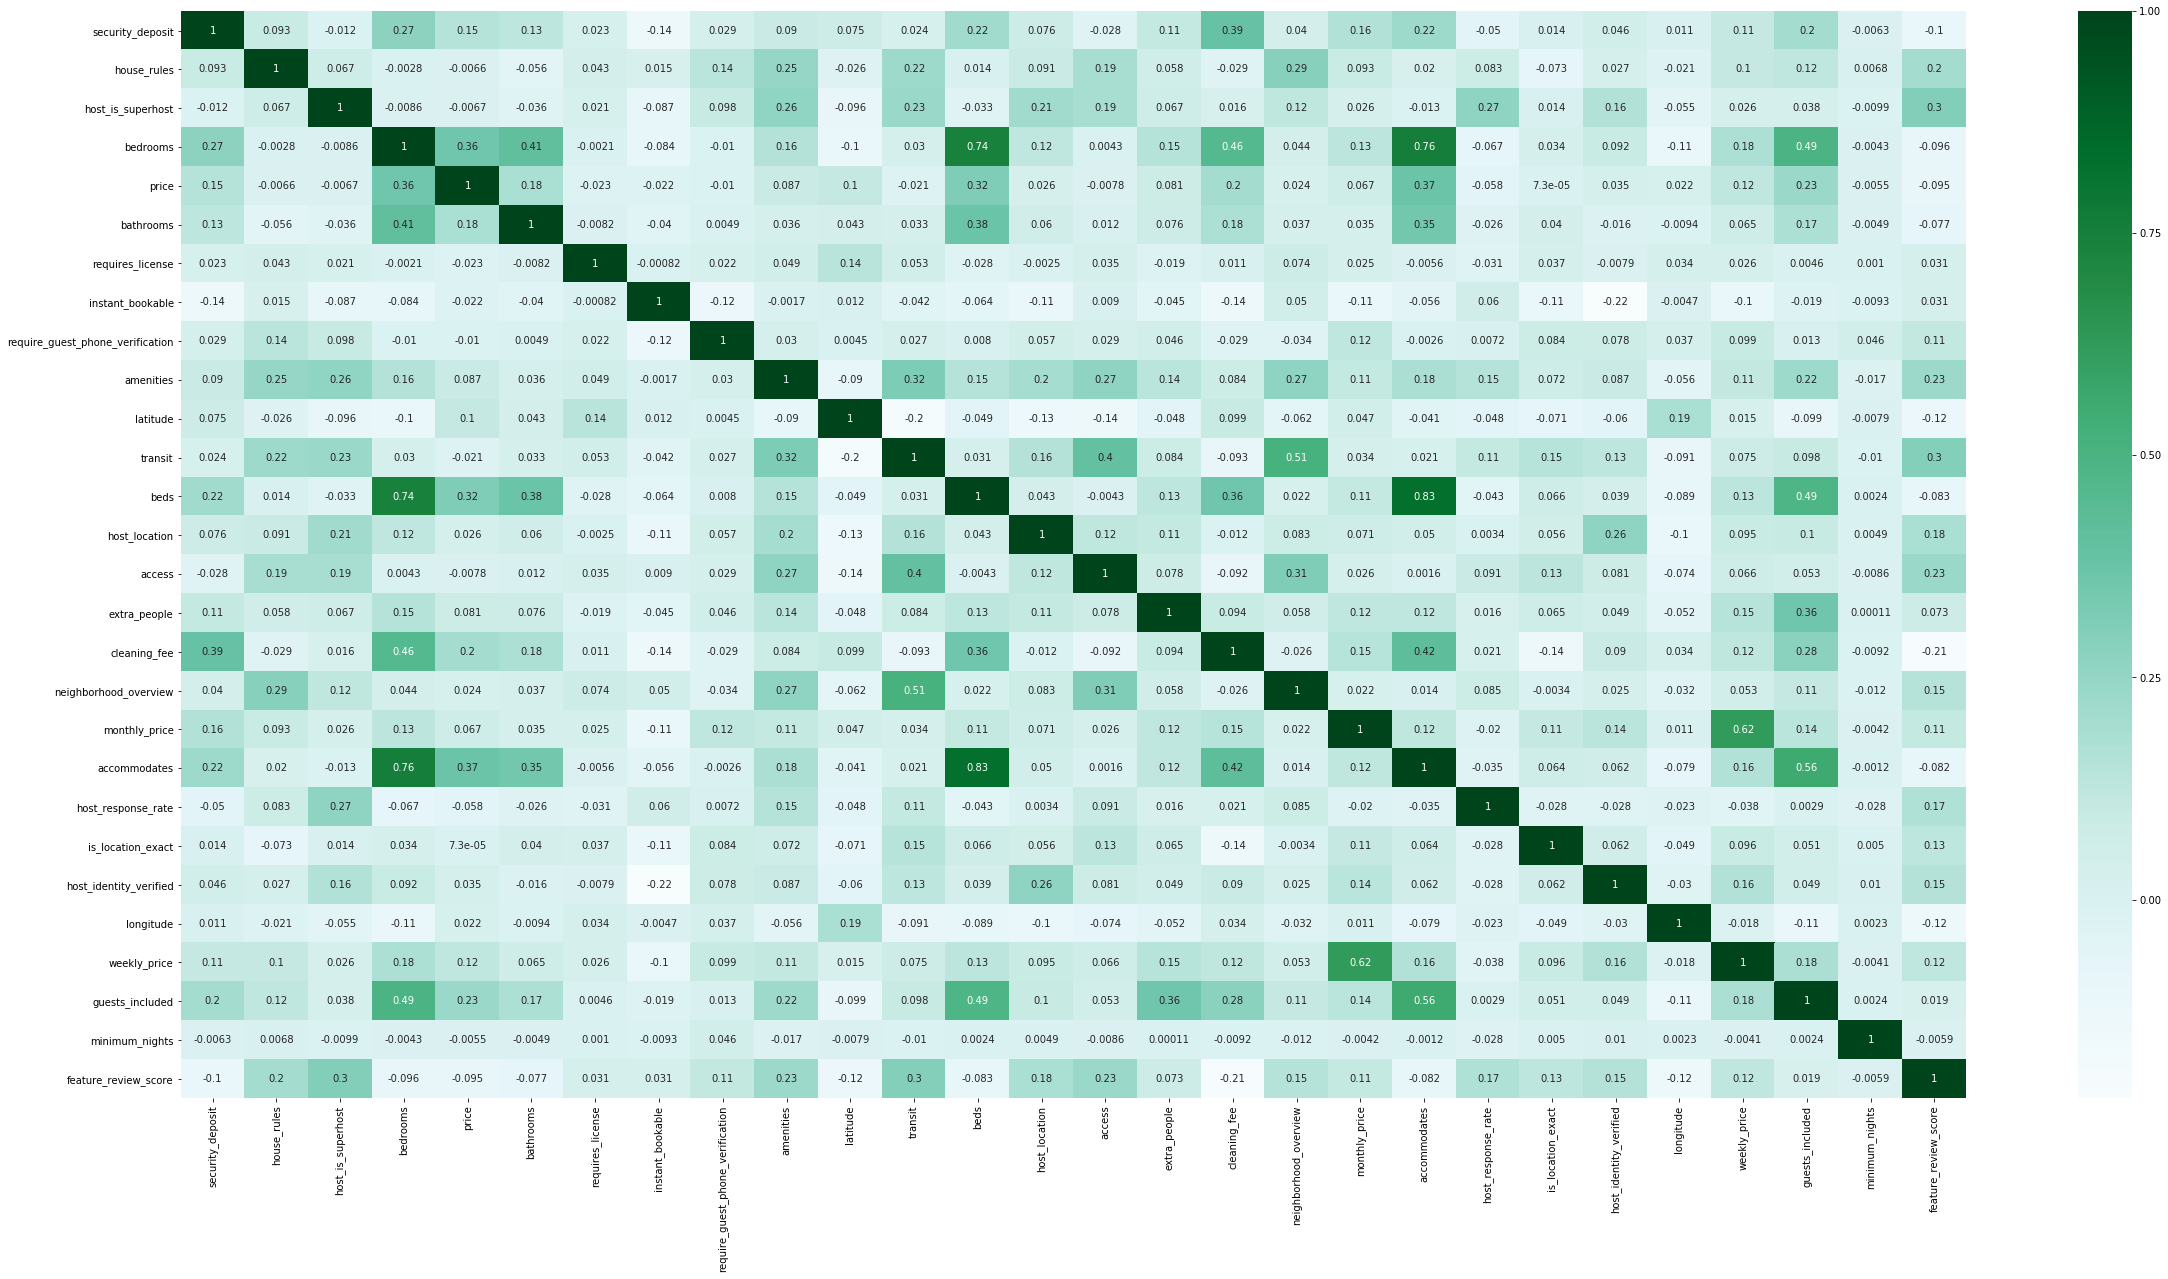

In [54]:
#Correlation plot
plt.rcParams["figure.figsize"] = "40,20"
sns.heatmap(listings_for_review.corr(), annot=True, cmap='BuGn')

In [52]:
unwanted_for_review = ['calendar_updated', 'name', 'summary', 'description','number_of_reviews_ltm','last_review',
                       'host_about', 'host_total_listings_count', 'id', 'space', 'maximum_nights', 'has_availability',
                       'host_has_profile_pic', 'availability_30', 'reviews_per_month', 'review_scores_accuracy',
                       'review_scores_communication', 'review_scores_rating', 'number_of_reviews', 'review_scores_location',
                       'review_scores_checkin', 'review_scores_cleanliness','review_scores_value' ]

In [53]:
listings_for_review = listing_clean.drop(unwanted_for_review, axis=1)
listings_for_review.head()

,security_deposit,house_rules,host_is_superhost,bedrooms,property_type,price,bed_type,bathrooms,requires_license,instant_bookable,...,is_location_exact,host_identity_verified,longitude,room_type,host_name,weekly_price,neighbourhood_cleansed,guests_included,minimum_nights,feature_review_score
0,100.0,110.0,1,1.0,Apartment,170.0,Real Bed,1.0,1,1,...,1,1,-122.43386,Entire home/apt,Holly,1120.0,Western Addition,2,1,17460.0
1,0.0,67.0,0,2.0,Apartment,235.0,Real Bed,1.0,1,0,...,1,1,-122.42102,Entire home/apt,Philip And Tania,1600.0,Bernal Heights,2,30,10878.0
2,200.0,88.0,0,1.0,Apartment,65.0,Real Bed,4.0,1,0,...,1,1,-122.45250,Private room,Aaron,485.0,Haight Ashbury,1,32,1445.0
3,200.0,44.0,0,1.0,Apartment,65.0,Real Bed,4.0,1,0,...,1,1,-122.45183,Private room,Aaron,490.0,Haight Ashbury,1,32,744.0
4,0.0,303.0,0,2.0,House,785.0,Real Bed,1.5,1,0,...,1,1,-122.43637,Entire home/apt,Rosy,0.0,Western Addition,2,7,2619.0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]), <a list of 36 Text xticklabel objects>)

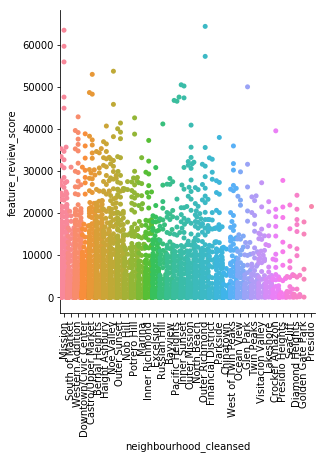

In [63]:
# remove host name
# convert latitude longitude to distance from center of the city
plt.rcParams["figure.figsize"] = "25,10"
sns.catplot('neighbourhood_cleansed', y="feature_review_score", kind='swarm',data=listings_for_review,
                   order=listing_clean['neighbourhood_cleansed'].value_counts().index)
plt.xticks(rotation=90)

## Feature Extraction and Scaling

In [55]:
# For extracting distance from Sanfranciso center to each latitude/longitude 
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

# For extracting distance to the major cities -San Francisco and Los Angeles
geolocator = Nominatim(timeout=3)
location = geolocator.geocode('San Francisco')
SF_lat_long = str(location.latitude) + ',' + str(location.longitude)

In [56]:
listings_for_review['lat_long'] = listings_for_review['latitude'].astype(str) + ',' + \
listings_for_review['longitude'].astype(str)

distance = []
for location in range (listings_for_review.shape[0]):
    distance.append(round(geodesic(listings_for_review['lat_long'][location], SF_lat_long).miles,2))

listings_for_review ['distance_to_SFcenter'] = distance

In [57]:
listings_for_review['host_since'] = listings_for_review['host_since'].dt.days

In [80]:
listings_continous = listings_for_review.select_dtypes(exclude='object').drop(['latitude','longitude'], axis=1)
# Scaling the data
scaler = MinMaxScaler(feature_range=(1,2))
listings_continous_scaled = pd.DataFrame(scaler.fit_transform(listings_continous),
                                         columns = listings_continous.columns.tolist())

In [87]:
listings_objects = pd.get_dummies(listings_for_review.select_dtypes(include='object').drop(['host_name', 'lat_long'], axis=1))
pred_review, resp_review = pd.concat([listings_continous,listings_objects],axis=1).drop(['feature_review_score'], 
                                                    axis=1), listings_for_review['feature_review_score']

## Linear Regression

In [88]:
#splitting the data into train and test splits
pred_train, pred_test, resp_train, resp_test = train_test_split(pred_review, resp_review, random_state=42)

#Fit model and predict
lr = LinearRegression()
lr.fit(pred_train, resp_train)
resp_pred = lr.predict(pred_test)

#Look at the results
values = np.append(lr.intercept_, lr.coef_)
names = np.append('Intercept', pred_train.columns)
results = pd.DataFrame(values, index=names, columns=['Coef'])
print(results)
print(f'Variance score of the model is {r2_score(resp_test, resp_pred)}')
print(f'Mean squared error of the model is {mean_squared_error(resp_test, resp_pred)}')

                                                      Coef
Intercept                                     -2354.295854
security_deposit                                 -0.424156
house_rules                                       2.335614
host_is_superhost                              2035.270635
bedrooms                                       -426.279518
price                                            -0.874550
bathrooms                                      -311.974606
requires_license                                 36.943289
instant_bookable                                963.956031
require_guest_phone_verification               1124.234604
amenities                                         2.162250
host_since                                        0.737300
transit                                           2.346342
beds                                            -63.130902
host_location                                   558.735226
access                                            1.6228

#### The variance score for the model is 32%, which tells us that a linear model woould not work for this dataset.

In [108]:
model = sm.OLS(resp_review, pred_review)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     feature_review_score   R-squared:                       0.327
Model:                              OLS   Adj. R-squared:                  0.317
Method:                   Least Squares   F-statistic:                     33.51
Date:                  Fri, 22 Mar 2019   Prob (F-statistic):               0.00
Time:                          23:51:24   Log-Likelihood:                -72004.
No. Observations:                  7151   AIC:                         1.442e+05
Df Residuals:                      7048   BIC:                         1.449e+05
Df Model:                           102                                         
Covariance Type:              nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
security_deposit                                   -0.4061      0.112     -3.634      0.000      -0.625      -0.187
house_rules                                         2.6512      0.237     11.165      0.000       2.186       3.117
host_is_superhost                                2075.6628    163.149     12.722      0.000    1755.841    2395.485
bedrooms                                         -387.5032    138.141     -2.805      0.005    -658.302    -116.704
price                                              -0.8602      0.246     -3.498      0.000      -1.342      -0.378
bathrooms                                        -288.5129    106.123     -2.719      0.007    -496.546     -80.480
requires_license                                  310.7185    891.020      0.349      0.727   -1435.949    2057.386
instant_bookable                                  982.1637    158.922      6.180      0.000     670.629    1293.698
require_guest_phone_verification                 1139.6667    306.788      3.715      0.000     538.270    1741.063
amenities                                           2.0355      0.434      4.691      0.000       1.185       2.886
host_since                                          0.7558      0.103      7.338      0.000       0.554       0.958
transit                                             2.6376      0.333      7.917      0.000       1.985       3.291
beds                                              -70.4975    113.979     -0.619      0.536    -293.931     152.936
host_location                                     392.7678    225.247      1.744      0.081     -48.785     834.321
access                                              1.3485      0.429      3.145      0.002       0.508       2.189
extra_people                                        0.9452      2.550      0.371      0.711      -4.053       5.944
cleaning_fee                                      -12.1785      1.113    -10.944      0.000     -14.360      -9.997
neighborhood_overview                              -0.8162      0.285     -2.860      0.004      -1.376      -0.257
monthly_price                                       0.2167      0.045      4.763      0.000       0.128       0.306
accommodates                                      248.9955     78.562      3.169      0.002      94.991     403.000
host_response_rate                               2928.1927   1072.963      2.729      0.006     824.862    5031.524
is_location_exact                                 727.6278    213.764      3.404      0.001     308.585    1146.670
host_identity_verified                            934.0332    162.784      5.738      0.000     614.928    1253.138
weekly_price                                 

In [148]:
type(results.pvalues)
#results.tvalues
#print('Parameters: ', results.params)
ols_results = pd.concat([results.params,results.pvalues,results.tvalues], axis=1)
ols_results.columns = ['Coefs','pvalues','tvalues']
ols_results.abs()[ols_results.pvalues < 1e-03].sort_values(by='pvalues', ascending=True)

,Coefs,pvalues,tvalues
host_is_superhost,2075.662765,1.120582e-36,12.722469
house_rules,2.651168,1.053626e-28,11.164874
cleaning_fee,12.178454,1.183030e-27,10.944085
transit,2.637593,2.800276e-15,7.917298
host_since,0.755833,2.408459e-13,7.338129
property_type_Guest suite,4020.378399,1.624972e-10,6.402663
instant_bookable,982.163748,6.760155e-10,6.180169
host_identity_verified,934.033192,9.984228e-09,5.737884
monthly_price,0.216705,1.946831e-06,4.762861
amenities,2.035461,2.763933e-06,4.691448


## Random Forest

In [90]:
#Using Random forest regressor
rforest = RandomForestRegressor(random_state=42)

#Performing a randomized search for finding best parameters
param_dist = {'n_estimators': range(500,1500,500),
              'max_depth': range(1,8,2),
              'max_features': range(1,20,2),
              'min_samples_split': range(500,2000,500)
             }
rforest_cv = RandomizedSearchCV(rforest, param_distributions=param_dist, cv=10, scoring='explained_variance')

In [91]:
rforest_cv.fit(pred_train, resp_train)
rforest_cv

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': range(500, 1500, 500), 'max_depth': range(1, 8, 2), 'max_features': range(1, 20, 2), 'min_samples_split': range(500, 2000, 500)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='explained_variance',
          verbose=0)

In [93]:
resp_pred = rforest_cv.predict(pred_test)
print(rforest_cv.score(pred_test, resp_test))
best_pred_new = rforest_cv.best_estimator_
best_pred_new

0.26180616421811453


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features=17, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=500, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=None, oob_score=False,
           random_state=42, verbose=0, warm_start=False)

Text(0, 0.5, 'Feature Importance')

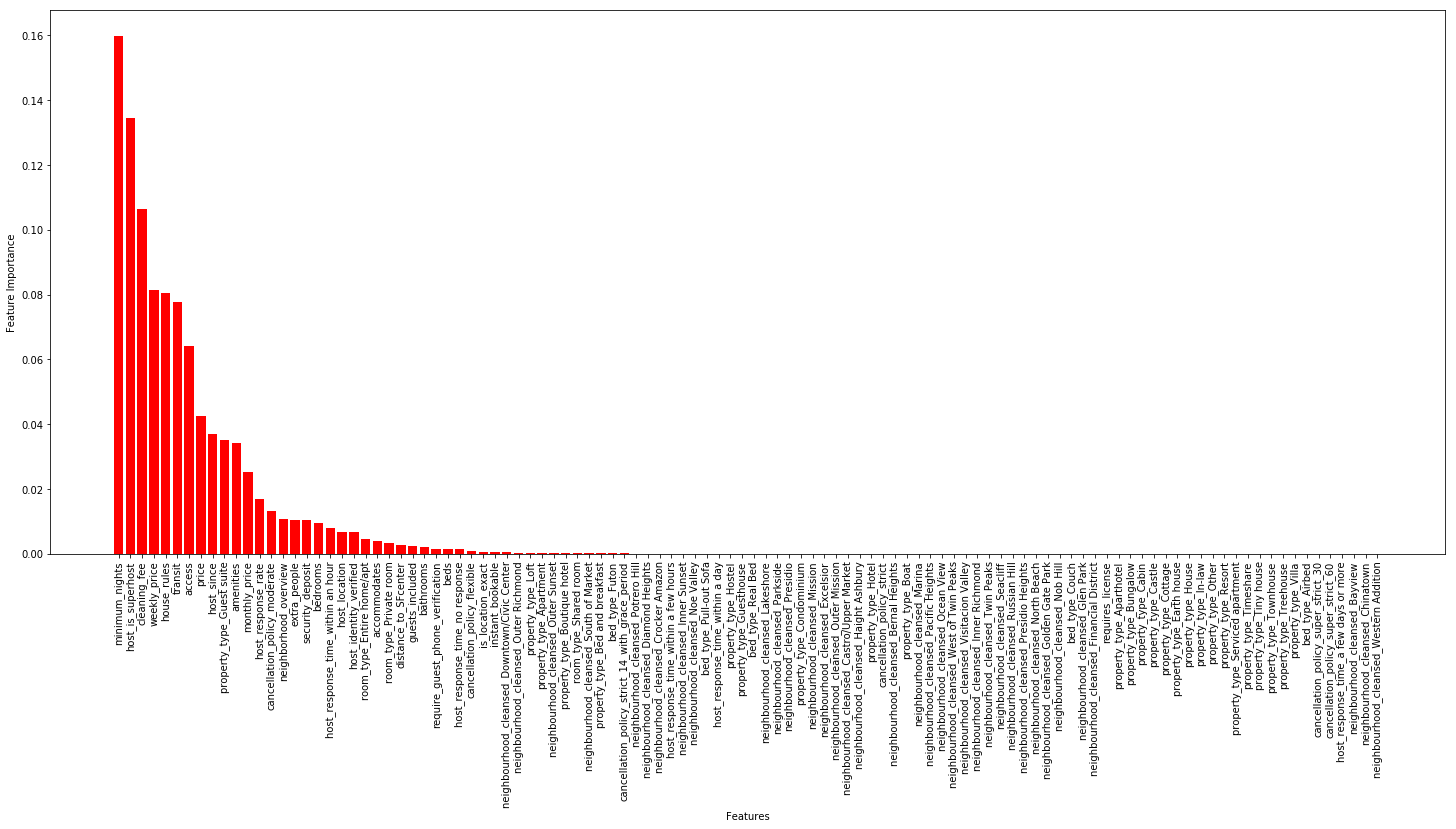

In [95]:
feature_importances = pd.DataFrame(best_pred_new.feature_importances_ ,
                                   index = pred_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.rcParams["figure.figsize"] = "25,10"
plt.bar(feature_importances.index, feature_importances.importance, color = "red")
plt.xlabel("Features")
plt.xticks(rotation=90)
plt.ylabel("Feature Importance")

#### Random forests variance score is only 26%, 6% less compared to linear regression.

## XGBoost 

In [134]:
# Using XG boosting
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01)
param_dist = {'n_estimators': [1000,1500,2000],
              'learning_rate': [0.01,0.001],
              'max_depth': [2,3,4]
             }
xgb_cv = RandomizedSearchCV(xgb, param_distributions=param_dist, cv=10)

In [135]:
xgb_cv.fit(pred_train, resp_train)
res_pred = xgb_cv.predict(pred_test)

In [139]:
print(f'Variance score for Gradient boost Algorithm is: {xgb_cv.score(pred_test, resp_test)}')
print(f'MSE : {mean_squared_error(resp_test,res_pred)}')
rough_errors = np.round(np.sqrt(mean_squared_error(resp_test,res_pred)),2)
print(f'Model makes rough miscalculations of about {rough_errors}')

Variance score for Gradient boost Algorithm is: 0.5415662297609467
MSE : 22376051.58226211
Model makes rough miscalculations of about 4730.33


In [143]:
xgb_cv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

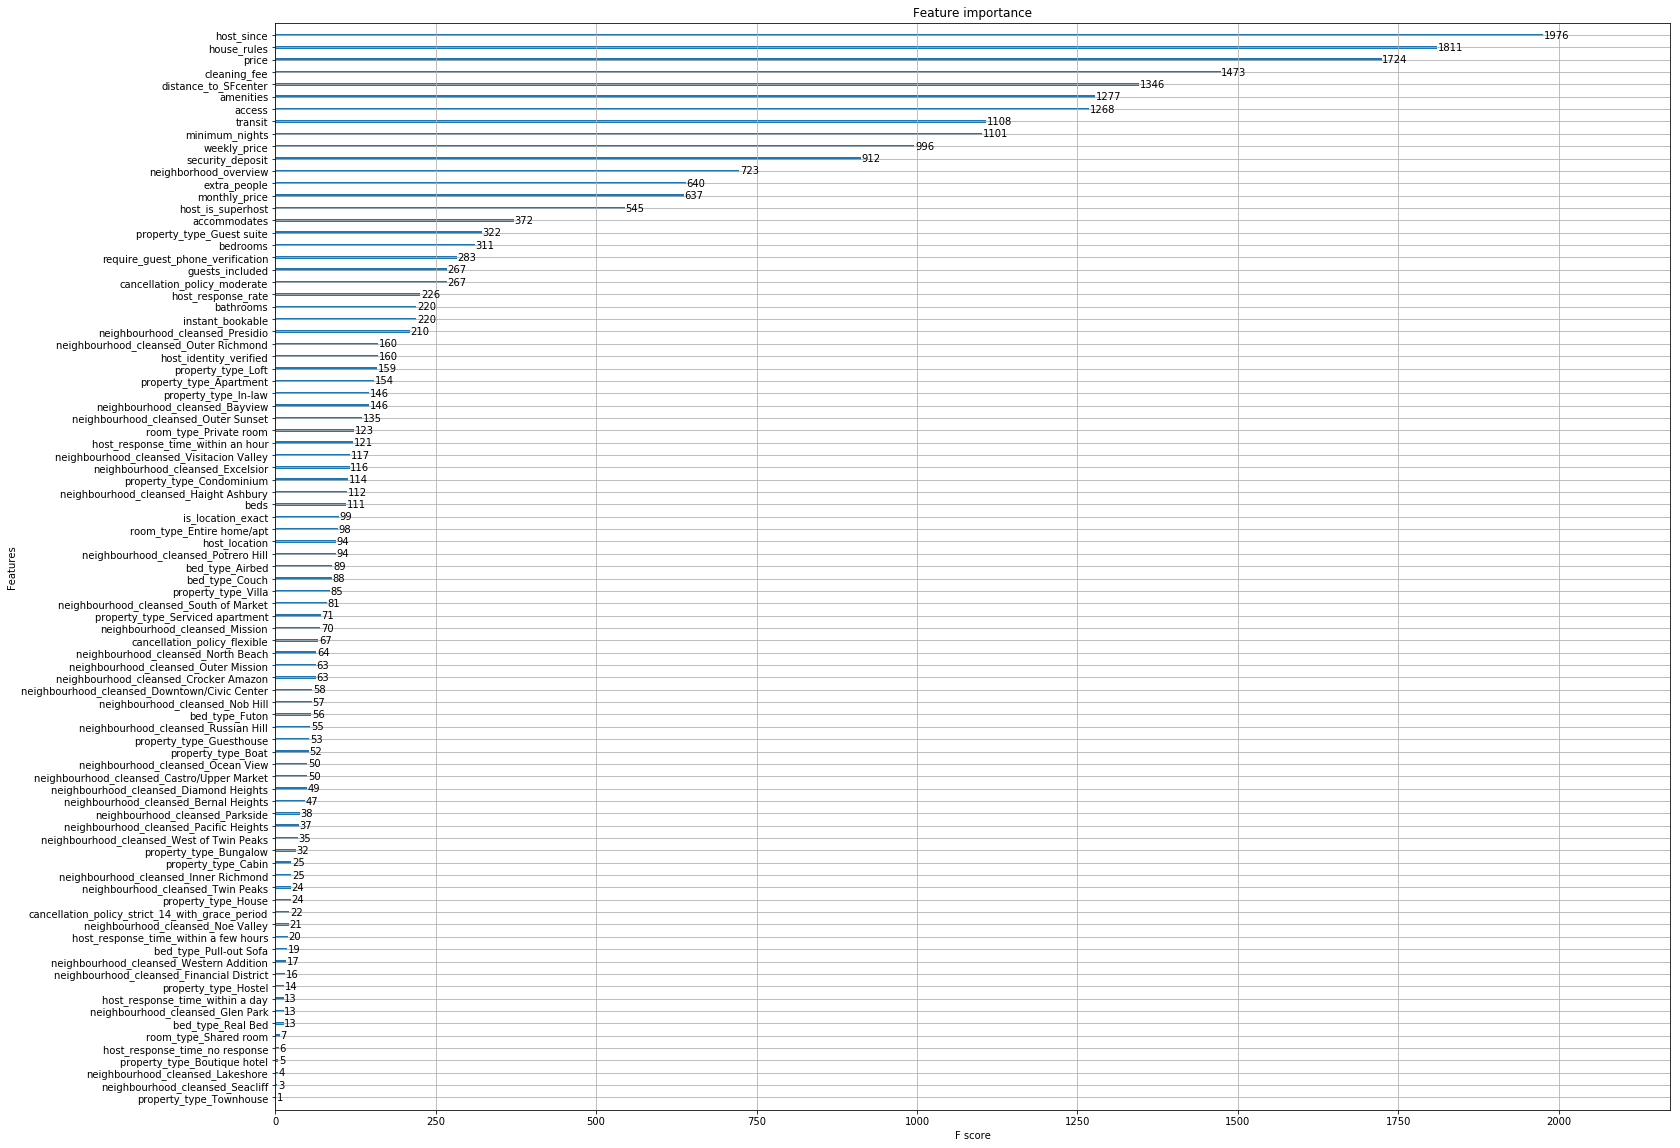

In [147]:
from xgboost import plot_importance
plt.rcParams["figure.figsize"] = "25,20"
plot_importance(xgb_cv.best_estimator_)

In [152]:
feature_importances = pd.DataFrame(xgb_cv.best_estimator_.feature_importances_ ,
                                   index = pred_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [158]:
feature_importances.head(20)

,importance
host_is_superhost,0.076752
minimum_nights,0.065999
neighbourhood_cleansed_Castro/Upper Market,0.048133
property_type_Guest suite,0.045017
weekly_price,0.044370
host_response_time_within an hour,0.039616
price,0.034534
neighbourhood_cleansed_Downtown/Civic Center,0.030160
monthly_price,0.029048
host_identity_verified,0.027809
